## Домашнее задание, урок 4

### 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### 2. Преобразование полей conversion и offer

In [3]:
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [4]:
df.rename(columns={"conversion":"target", "offer": "treatment"}, inplace=True)

In [5]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

In [7]:
df.loc[df['treatment'] != 0, 'treatment'] = 1

In [8]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [9]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment         object
target             int64
dtype: object

In [10]:
# Также преобразуем поле treatment к типу int.
df['treatment'] = df['treatment'].astype(np.int64)

In [11]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

### 3. Разбиение на тренировочную и тестовую выборку

In [12]:
# Разобьем данные на train и test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], test_size=0.2, random_state=0)

In [13]:
# Разобьем train на train и val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [14]:
X_train.shape

(35840, 8)

In [15]:
X_test.shape

(12800, 8)

In [16]:
X_val.shape

(15360, 8)

In [17]:
# Создадим dataframe с флагом treatment
treat_train = X_train['treatment']
treat_val = X_val['treatment']

In [18]:
# Удалим колонку'treatment' из данных
X_train.drop('treatment', axis=1, inplace=True)
X_test.drop('treatment', axis=1, inplace=True)
X_val.drop('treatment', axis=1, inplace=True)

### 4. Feature Engineering

In [19]:
# Выделим в два отдельных списка категориальные и количественные признаки.
cat_features = ['zip_code', 'channel']
num_features = X_train.drop(cat_features, axis=1).columns
num_features

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral'], dtype='object')

In [20]:
df[cat_features]

,zip_code,channel
0,Surburban,Phone
1,Rural,Web
2,Surburban,Web
3,Rural,Web
4,Urban,Web
...,...,...
63995,Urban,Web
63996,Urban,Phone
63997,Urban,Phone
63998,Surburban,Multichannel


In [21]:
# Применим StandardScaler для стандартизации значений признаков.
scaler = StandardScaler()
X_train = pd.concat([pd.DataFrame(scaler.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index), X_train[cat_features]], axis=1)
X_val = pd.concat([pd.DataFrame(scaler.transform(X_val[num_features]), columns=num_features, index=X_val.index), X_val[cat_features]], axis=1)
X_test = pd.concat([pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index), X_test[cat_features]], axis=1)

### 5. Uplift-моделирование

In [22]:
# Создадим модель для сохранения метрик
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': [] 
}

#### Способ 1: одна модель с признаком коммуникации

uplift@20%: 0.0920
uplift@10%: 0.1023


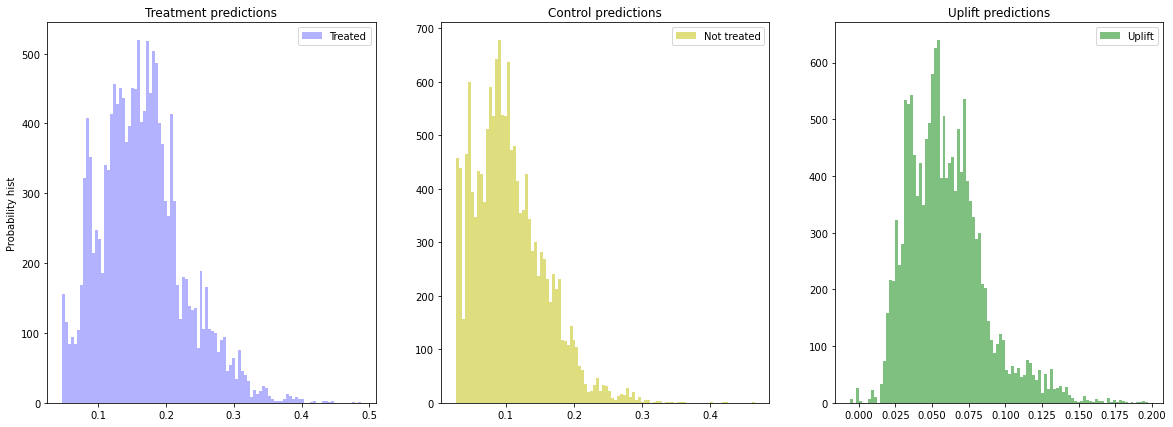

In [23]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

# Делаем расчеты для uplift@20%
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score)

# Делаем расчеты для uplift@10%
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score:.4f}')

models_results['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### Способ 2: две независимые модели

uplift@20%: 0.0946
uplift@10%: 0.1101


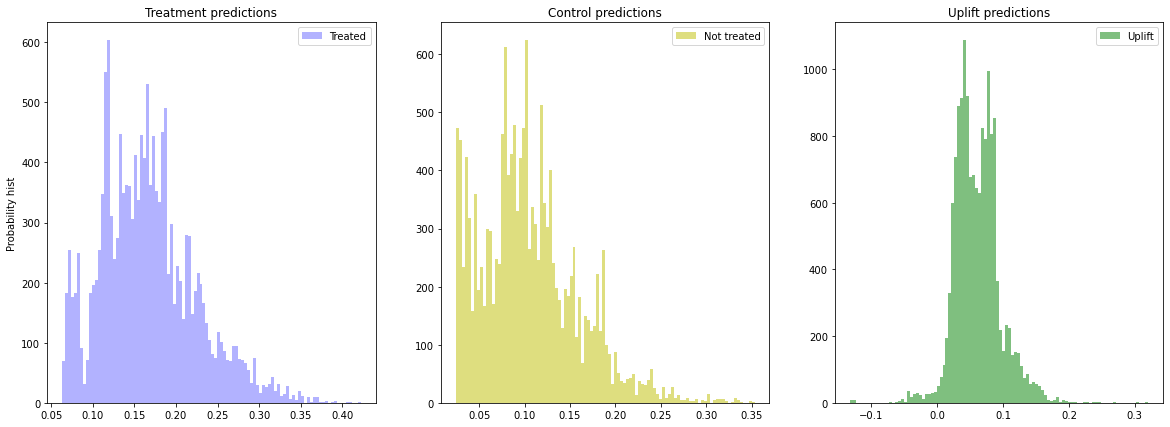

In [24]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

# Делаем расчеты для uplift@20%
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {tm_score:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score)

# Делаем расчеты для uplift@10%
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {tm_score:.4f}')

models_results['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### Способ 3: модель с трансформацией таргета

uplift@20%: 0.0868
uplift@10%: 0.1032


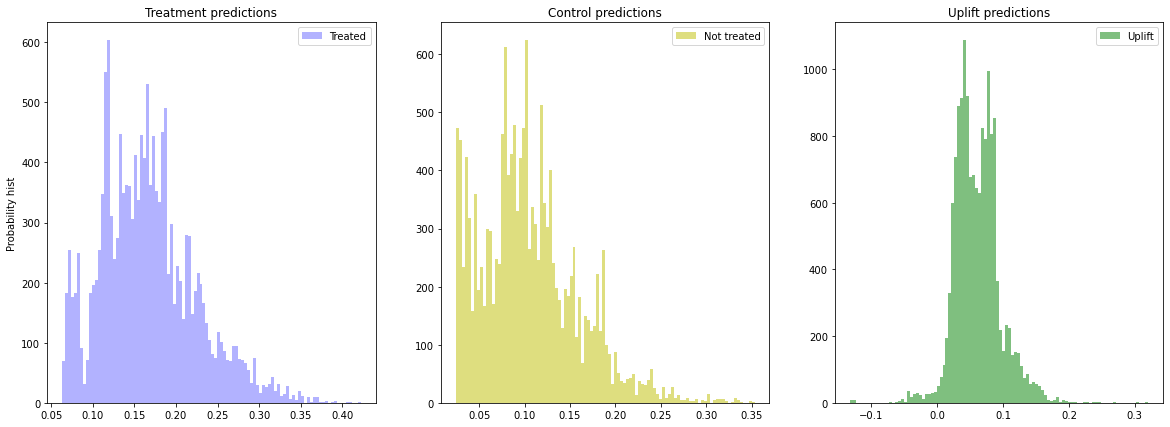

In [25]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

# Делаем расчеты для uplift@20%
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {ct_score:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score)

# Делаем расчеты для uplift@10%
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {ct_score:.4f}')

models_results['uplift@10%'].append(ct_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 6. Сравнение метрик

In [26]:
pd.DataFrame(models_results, index=models_results['approach']).drop('approach', axis=1)

,uplift@20%,uplift@10%
SoloModel,0.092031,0.102298
TwoModels,0.094638,0.110096
ClassTransformation,0.086771,0.103221
